# Banana classification example

This example notebook accompanies the paper submission "Stationary Activations for Uncertainty Calibration in Deep Learning" and is related to the illustrative toy example in Fig. 1.

Import packages.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

Specify parameters for model specification and training.

In [9]:
LR = 0.02 #learning rate
n_epochs = 2000
batch_size = 400 #full batch

MC = 100 #number of MC dropout samples
dropout = 0.2

Specify matern activation function with precalculated scaling coefficients. By default the Matern-5/2 with a length-scale 0.5 is chosen to replicate what was done in the paper. This activation function is Equation 9 in the paper.

In [10]:
def sigma(x, nu_ind=2, ell=0.5):
    """Implements the Matern activation function denoted as sigma(x) in Equation 9.
    sigma(x) corresponds to a Matern kernel, with specified smoothness
    parameter nu and length-scale parameter ell.
    
    Args:
      x: Input to the activation function
      device: A torch.device object
      nu_ind: Index for choosing Matern smoothness (look at nu_list below)
      ell: Matern length-scale, only 0.5 and 1 available with precalculated scaling coefficients
    """
    nu_list = [1/2, 3/2, 5/2, 7/2, 9/2] #list of available smoothness parameters
    nu = torch.tensor(nu_list[nu_ind]) #smoothness parameter
    lamb =  torch.sqrt(2*nu)/ell #lambda parameter
    v = nu+1/2
    # Precalculated scaling coefficients for two different lengthscales (q divided by Gammafunction at nu + 0.5)
    ell05A = [4.0, 19.595917942265423, 65.31972647421809, 176.69358285524189, 413.0710073859664]
    ell1A = [2.0, 4.898979485566356, 8.16496580927726, 11.043348928452618, 12.90846898081145]
    if ell == 0.5:
        A = ell05A[nu_ind]
    if ell == 1:
        A = ell1A[nu_ind]
    y = A*torch.sign(x)*torch.abs(x)**(v-1)*torch.exp(-lamb*torch.abs(x))
    y[x<0] = 0 # Values at x<0 must all be 0
    return y

Specify neural network architecture: fully connected network with one hidden layer of 50 nodes.

In [11]:
class littleMLP(nn.Module):

    def __init__(self, num_classes=2, dropout=0.2):
        super(littleMLP, self).__init__()

        #FC layers
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, num_classes)
        
        #Dropout layer
        self.drop_layer = nn.Dropout(p=dropout)

    def forward(self, x):
        x = sigma(self.fc1(x))
        x = self.drop_layer(x)
        x = self.fc2(x)
        return x

Initialize the network.

In [12]:
MLP = littleMLP(dropout = dropout)

Load and preprocess data.

In [14]:
# Download data from .csv files
data = pd.read_csv("../data/datapoints.csv", header = None, prefix = 'col') #2D points
classes = pd.read_csv("../data/classes.csv", header = None, prefix = 'col') #class labels
N_samples = len(classes) #Number of training samples

# Data to numpy arrays
data_array = np.zeros((N_samples,2))
data_array[:,0] = np.asarray(data.col0[:])
data_array[:,1] = np.asarray(data.col1[:])
class_array = np.asarray(classes.col0)

# Data to torch tensors for training
training_data = torch.from_numpy(data_array).float()
training_targets = torch.from_numpy(class_array).long()

Initialize training setup.

In [15]:
criterion = nn.CrossEntropyLoss() #Loss function to be used
optimizer = optim.Adam(MLP.parameters(), lr=LR)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[n_epochs/8, n_epochs/4, n_epochs/2], gamma=0.1)

accuracies = np.zeros(n_epochs) #Initialize array for saving mid training classification accuracies

Training loop.

In [16]:
for epoch in tqdm(range(n_epochs)):  #loop over the dataset multiple times
    #random index for data shuffling for epochs
    index = np.arange(0,N_samples)
    random.shuffle(index)
    
    #shuffle data for each epoch
    curr_input_set = training_data[index,:]
    curr_target_set = training_targets[index]
    curr_ind = 0
    while curr_ind < N_samples: #Loop through all batches (with the default batch size just one iteration)
        new_ind = min(N_samples, curr_ind + batch_size)
        outputs = MLP(curr_input_set[curr_ind:new_ind,:]) #Calculate network outputs
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, curr_target_set[curr_ind:new_ind]) #Calculate loss
        curr_ind = new_ind
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward() #backpropagate gradients
        optimizer.step() #update network weights
    scheduler.step() #Update learning rate

    MLP.eval()
    outputs = MLP(training_data) #Network outputs for accuracy tracking
    outputs = torch.squeeze(outputs).detach().numpy()
    preds = np.argmax(outputs, axis=1) #Predicted classes
    accuracies[epoch] = np.sum(class_array.astype(int) == preds)/N_samples #Fraction of correct predictions
    MLP.train()

100%|██████████| 2000/2000 [00:06<00:00, 289.54it/s]


Plot classification accuracy on training samples for each epoch.

Text(0, 0.5, 'accuracy')

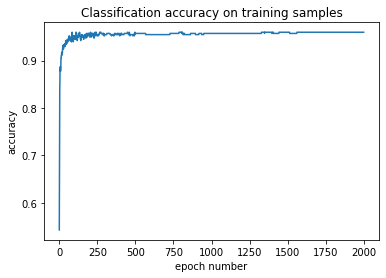

In [17]:
plt.figure()
plt.plot(accuracies)
plt.title('Classification accuracy on training samples')
plt.xlabel('epoch number')
plt.ylabel('accuracy')

Generate a grid of test samples.

In [18]:
gridwidth = 300 #number of test samples in each dimension
gridlength = 3.75 #how far to extend the test samples around 0 in both dimensions
x_vals = np.linspace(-gridlength,gridlength,gridwidth)
y_vals = np.linspace(-gridlength,gridlength,gridwidth)
grid_samples = np.zeros((gridwidth*gridwidth,2))
for i in range(gridwidth):
    for j in range(gridwidth):
        grid_samples[i*gridwidth + j, 0] = x_vals[i]
        grid_samples[i*gridwidth + j, 1] = y_vals[j]

grid_set = torch.from_numpy(grid_samples).float() #Grid samples to torch tensor

Model testing on a grid of test samples to get the predicted classes.

In [19]:
MLP.eval()

#Predict grid samples to classes without MC dropout
grid_outputs = F.softmax(MLP(grid_set), dim = -1)
grid_outputs = torch.squeeze(grid_outputs).detach().numpy()
grid_preds = np.argmax(grid_outputs, axis=1) #get predicted class
shaped_grid_preds = np.reshape(grid_preds,(gridwidth,gridwidth)).T #reshape to the shape of the test grid

Model testing on a grid of test samples using MC dropout to get uncertainty estimates.

In [20]:
# Function to allow dropout in model evaluation
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

MLP.apply(apply_dropout) #allow dropout in evaluation mode

#MC dropout samples
MCoutputs = np.zeros((gridwidth*gridwidth,2,MC))
for i in tqdm(range(MC)):
    grid_outputs = F.softmax(MLP(grid_set), dim = -1)
    grid_outputs = torch.squeeze(grid_outputs).detach().numpy()
    MCoutputs[:,:,i] = grid_outputs
mean_MCoutputs = np.mean(MCoutputs,axis=2)
sample_std = np.sqrt(mean_MCoutputs[:,0]*mean_MCoutputs[:,1]) #Bernoulli distribution style standard deviation
shaped_std = np.reshape(sample_std,(gridwidth,gridwidth)).T  #reshape to the shape of the test grid

100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Plotting results: decision boundaries in black, training samples as orange and blue circles, and uncertainty as the colormap ranging from white to grey.

/u/54/meronel1/unix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/u/54/meronel1/unix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  del sys.path[0]


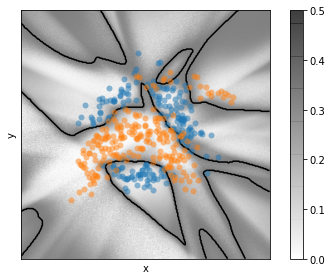

In [21]:
xv, yv = np.meshgrid(x_vals, y_vals) #Sample grid as a meshgrid

fig1, ax1 = plt.subplots()
im1 = ax1.imshow(shaped_std,cmap='gray_r',extent=[-gridlength, gridlength, -gridlength, gridlength],origin='lower',alpha=0.5, vmin = 0, vmax = 0.5)
fig1.colorbar(im1)
ax1.plot(data_array[class_array==0,0], data_array[class_array==0,1], 'oC0', mew=0, alpha=0.5)
ax1.plot(data_array[class_array==1,0], data_array[class_array==1,1], 'oC1', mew=0, alpha=0.5)
ax1.contour(xv, yv, shaped_grid_preds, [0.5], colors='k')
ax1.grid(False)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_xticks([], [])
ax1.set_yticks([], [])
ax1.set_xlabel('x')
ax1.set_ylabel('y')

fig1.tight_layout() 